In [1]:
import pandas as pd
import sweetviz as sv
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

# increase column number display in pandas
pd.set_option('display.max_columns', 100)

def read_csv():
    # read csv and parse dates column to datetime
    df = pd.read_csv("loan.csv", parse_dates=['issue_d'])
    return df

def make_train_test(df):
    # split data to train and test
    sorted_df = df[df['loan_status'] != 'Current'].reset_index(drop=True)
    sorted_df["loan_status"] = sorted_df["loan_status"].map({"Fully Paid": 0, "Charged Off": 1})
    X = sorted_df.drop('loan_status', axis=1)
    y = sorted_df['loan_status']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train.reset_index(drop=True,inplace=True)
    X_test.reset_index(drop=True,inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    return X_train, X_test, y_train, y_test
    

df = read_csv()
df_train, df_test, df_train_y, df_test_y = make_train_test(df)

# # check data by sweetviz
# my_report = sv.analyze(df_train)
# my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

df_train.head()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,...,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,746087,944733,2500,2500,2500.0,36 months,17.49%,89.75,D,D5,"Homemaker Service of the Metro Area, Inc",2 years,RENT,43000.0,Not Verified,May-11,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt Consolidation Loan,190xx,PA,13.31,0,Jul-98,3,35.0,NaN,3,0,3084,71.70%,17,f,0.0,0.0,2240.780000,2240.78,1501.36,652.41,29.953203,57.06,0.7000,Jun-13,200.00,NaN,Oct-13,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,764500,965232,5000,5000,5000.0,36 months,5.42%,150.80,A,A1,Arizona Department of Education,3 years,MORTGAGE,60000.0,Source Verified,May-11,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 05/25/11 > I work in an ar...,medical,Medical,852xx,AZ,3.16,0,Apr-96,0,NaN,NaN,7,0,6174,18.90%,26,f,0.0,0.0,5428.767193,5428.77,5000.00,428.77,0.000000,0.00,0.0000,Jun-14,165.37,NaN,May-16,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,973488,1195496,35000,35000,35000.0,60 months,20.89%,944.71,F,F1,Terumo Cardiovascular,2 years,MORTGAGE,158000.0,Verified,Oct-11,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 10/18/11 > Unfortunately I...,debt_consolidation,debt consolidation,980xx,WA,16.81,1,Jan-94,0,11.0,NaN,10,0,38283,70.30%,27,f,0.0,0.0,41731.380000,41731.38,17250.48,20610.17,0.000000,3870.73,696.7314,Jul-15,100.00,NaN,Jul-15,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,661374,845833,8000,8000,8000.0,36 months,10.00%,258.14,B,B2,USAF,6 years,MORTGAGE,78000.0,Source Verified,Jan-11,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,CC Payment,325xx,FL,20.02,0,Nov-98,1,27.0,NaN,10,0,39613,80.30%,26,f,0.0,0.0,9234.866201,9234.87,7999.99,1234.88,0.000000,0.00,0.0000,Jul-13,2027.10,NaN,Jul-13,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,605843,777213,2400,2400,2400.0,36 months,6.17%,73.20,A,A3,Ohio University,10+ years,RENT,35000.0,Not Verified,Oct-10,n,https://lendingclub.com/browse/loanDetail.acti...,Borro

In [2]:
class Base():    
    def fit(self, input_df):
        return self.transform(input_df)
        
    def transform(self, input_df):
        raise NotImplementedError

In [3]:
class DeleteUninformableColumn(Base):
    def __init__(self):
        self.deleted_columns = []
        
    def fit(self, input_df):
        # delete columns which has more than 50% missing values
        origin_columns = set(input_df.columns)
        deleted_df = input_df.dropna(thresh=len(df)/2, axis=1)
        
        # check columns which has same values of 90% data and delete it.
        for col in deleted_df.columns:
            if deleted_df[col].value_counts().iloc[0] > len(deleted_df)*0.9:
                output_df = deleted_df.drop(col, axis=1)
        self.deleted_columns=set(output_df.columns)-origin_columns
        print(f"delete columns: {self.deleted_columns}")
        return self.transform(input_df)
    
    def transform(self, input_df):
        output_df = input_df.drop(self.deleted_columns, axis=1)
        return output_df
    
delete_colums = DeleteUninformableColumn()
df_train = delete_colums.fit(df_train)
df_test = delete_colums.transform(df_test)
    



delete columns: set()


In [4]:
class PreprocessFeatures(Base):
    def transform_term(self, input_df):
        output_df = pd.DataFrame()
        output_df['converted_term'] = input_df['term'].str.replace('months', '').astype(int)
        return output_df

    def transform_int_rate(self, input_df):
        output_df = pd.DataFrame()
        output_df['converted_int_rate'] = input_df['int_rate'].str.replace('%', '').astype(float)
        return output_df
    
    def transform_revol_util(self, input_df):
        output_df = pd.DataFrame()
        output_df['converted_revol_util'] = input_df['revol_util'].str.replace('%', '').astype(float)
        return output_df
    
    def transform(self, input_df):
        input_df["term"] = self.transform_term(input_df)
        input_df["int_rate"] = self.transform_int_rate(input_df)
        input_df["revol_util"] = self.transform_revol_util(input_df)
        return input_df

preprocess = PreprocessFeatures()
df_train = preprocess.fit(df_train)
df_test = preprocess.transform(df_test)
df_train.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,...,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,746087,944733,2500,2500,2500.0,36,17.49,89.75,D,D5,"Homemaker Service of the Metro Area, Inc",2 years,RENT,43000.0,Not Verified,May-11,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt Consolidation Loan,190xx,PA,13.31,0,Jul-98,3,35.0,NaN,3,0,3084,71.7,17,f,0.0,0.0,2240.780000,2240.78,1501.36,652.41,29.953203,57.06,0.7000,Jun-13,200.00,NaN,Oct-13,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,764500,965232,5000,5000,5000.0,36,5.42,150.80,A,A1,Arizona Department of Education,3 years,MORTGAGE,60000.0,Source Verified,May-11,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 05/25/11 > I work in an ar...,medical,Medical,852xx,AZ,3.16,0,Apr-96,0,NaN,NaN,7,0,6174,18.9,26,f,0.0,0.0,5428.767193,5428.77,5000.00,428.77,0.000000,0.00,0.0000,Jun-14,165.37,NaN,May-16,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,973488,1195496,35000,35000,35000.0,60,20.89,944.71,F,F1,Terumo Cardiovascular,2 years,MORTGAGE,158000.0,Verified,Oct-11,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 10/18/11 > Unfortunately I...,debt_consolidation,debt consolidation,980xx,WA,16.81,1,Jan-94,0,11.0,NaN,10,0,38283,70.3,27,f,0.0,0.0,41731.380000,41731.38,17250.48,20610.17,0.000000,3870.73,696.7314,Jul-15,100.00,NaN,Jul-15,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,661374,845833,8000,8000,8000.0,36,10.00,258.14,B,B2,USAF,6 years,MORTGAGE,78000.0,Source Verified,Jan-11,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,CC Payment,325xx,FL,20.02,0,Nov-98,1,27.0,NaN,10,0,39613,80.3,26,f,0.0,0.0,9234.866201,9234.87,7999.99,1234.88,0.000000,0.00,0.0000,Jul-13,2027.10,NaN,Jul-13,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,605843,777213,2400,2400,2400.0,36,6.17,73.20,A,A3,Ohio University,10+ years,RENT,35000.0,Not Verified,Oct-10,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 10/28/10 > The purpose of ...,other

In [5]:
import category_encoders as ce

class ordinal_encoding_based_on_frequency_encoding(Base):
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, input_df):
        self.encoders_ = {}  # Dictionary to hold individual encoders
        self.reverse_mappings_ = {}  # Dictionary to hold reverse mappings
        output_df = pd.DataFrame()
        for col in self.cols:
            value_counted = input_df[col].value_counts().sort_values()
            mapping_dict = {value: i for i, value in enumerate(value_counted.index)}
            reverse_mapping_dict = {i: value for value, i in mapping_dict.items()}  # Store reverse mapping
            self.reverse_mappings_[col] = reverse_mapping_dict  # Save as class attribute
            mapping = [{"col": col, "mapping": mapping_dict}]
            encoder = ce.OrdinalEncoder(mapping=mapping)
            self.encoders_[col] = encoder  # Save encoder to dictionary
            encoded_col = encoder.fit_transform(input_df[col])
            output_df = pd.concat([output_df, encoded_col.add_prefix(f"ordinal_{col}_")], axis=1)
        return output_df
    
    def transform(self, input_df):
        output_df = pd.DataFrame()
        for col, encoder in self.encoders_.items():
            encoded_col = encoder.transform(input_df[col])
            output_df = pd.concat([output_df, encoded_col.add_prefix(f"ordinal_{col}_")], axis=1)
        return output_df

# test = ordinal_encoding_based_on_frequency_encoding("grade")
# test.fit(X_train)
# test.transform(X_test)

In [6]:
# stacked predictionによりテキストをメタ特徴量化する。
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import Binarizer
from scipy.sparse import hstack
from sklearn.linear_model import ElasticNet,LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

class text_out_of_fold_prediction(Base):
  def __init__(self, col):
    self.nfolds = 5
    self.seed = 71
    self.col = col
    self.models = []
    self.regression = False
    self.scores = []
    

    
  def fit(self, input_df, y):
    x = input_df[self.col].fillna("nan")
    # self.vectorizer_ = TfidfVectorizer(max_features=100)
    self.vectorizer_ = CountVectorizer(max_features=100)
    x = self.vectorizer_.fit_transform(x)
    self.binerizer_ = Binarizer()
    x = self.binerizer_.fit_transform(x)
    
    if self.regression:
      fold = KFold(n_splits=self.nfolds, random_state=self.seed, shuffle=True)
    else:
      fold = StratifiedKFold(n_splits=self.nfolds, random_state=self.seed, shuffle=True)
    oof_train = np.zeros(len(input_df))
    # stacked prediction
    for i, (train_idx, valid_idx) in enumerate(fold.split(input_df[self.col], y)):
      train_x, train_y = x[train_idx], y.loc[train_idx]
      valid_x, valid_y = x[valid_idx], y.loc[valid_idx]
      
      if self.regression:
        clf = ElasticNet(random_state=self.seed)
        clf.fit(train_x, train_y)
        pred_y = clf.predict(valid_x)
        score = mean_squared_error(valid_y, pred_y)
      else:
        clf = LogisticRegression(penalty='elasticnet',solver='saga',random_state=self.seed, max_iter=10000, C=1.0, l1_ratio=0.5, class_weight='balanced')
        clf.fit(train_x, train_y)
        pred_y = clf.predict_proba(valid_x)[:,1]
        score = roc_auc_score(valid_y, pred_y)  
      print(f'CV Score of Fold_{i} is {score}')
      self.models.append(clf)
      self.scores.append(score)
      oof_train[valid_idx]= pred_y
      
    print(f"mean score is {np.mean(self.scores)}")
    output_df = pd.DataFrame()
    output_df[self.col] = oof_train
    return output_df.add_prefix("predicted_")
        
  def transform(self, input_df):
    x = input_df[self.col].fillna("nan")
    x = self.vectorizer_.transform(x)
    x = self.binerizer_.transform(x)
    oof_test = np.zeros(len(input_df))
    if self.regression:
      for clf in self.models:
        oof_test += clf.predict(x)
    else:
      for clf in self.models:
        oof_test += clf.predict_proba(x)[:,1]
    oof_test /= self.nfolds
    output_df = pd.DataFrame()
    output_df[self.col] = oof_test
    return output_df.add_prefix("predicted_")

text_pred = text_out_of_fold_prediction("desc")
text_pred.fit(df_train, df_train_y)
text_pred.transform(df_train)

CV Score of Fold_0 is 0.5768427742609396
CV Score of Fold_1 is 0.5701548366929711
CV Score of Fold_2 is 0.5678656956112647
CV Score of Fold_3 is 0.5809929856177366
CV Score of Fold_4 is 0.5824072957128036
mean score is 0.575652717579143


,predicted_desc
0,0.498457
1,0.371252
2,0.490762
3,0.498457
4,0.245892
...,...
30856,0.473683
30857,0.364380
30858,0.556044
30859,0.420378


In [7]:
# テキストの重要堂やカウントを整理する
class text_check_insight():
    def __init__(self, col):
        self.col = col
        self.regression =False
        self.seed = 1
 
    def create_words_summary(self, clf, x):
        output_df = pd.DataFrame()
        output_df["features"] = self.vectorizer_.get_feature_names_out()
        output_df["wordcounts"] = (np.array(x.sum(axis=0)).flatten())
        output_df["coefs"] = clf.coef_.flatten()
        return output_df.sort_values(by="coefs").reset_index(drop=True)
    
    def __call__(self, input_df, y):
        x = input_df[self.col].fillna("nan")
        self.vectorizer_ = CountVectorizer(max_features=1000)
        x = self.vectorizer_.fit_transform(x)
        self.binerizer_ = Binarizer()
        x = self.binerizer_.fit_transform(x)
        
        if self.regression:
            clf = ElasticNet(random_state=self.seed)
        else:
            clf = LogisticRegression(penalty='elasticnet',solver='saga',random_state=self.seed, max_iter=10000, C=1.0, l1_ratio=0.5, class_weight='balanced')
        clf.fit(x, y)
        return self.create_words_summary(clf, x)

    
test = text_check_insight("desc")
df_word_summary = test(df_train, df_train_y)
df_word_summary

,features,wordcounts,coefs
0,motorcycle,253,-0.990882
1,toward,232,-0.949659
2,engagement,146,-0.930722
3,goes,172,-0.888157
4,lived,123,-0.827581
...,...,...,...
995,decent,125,0.837859
996,law,170,0.887497
997,restaurant,87,0.935750
998,spent,129,0.956557


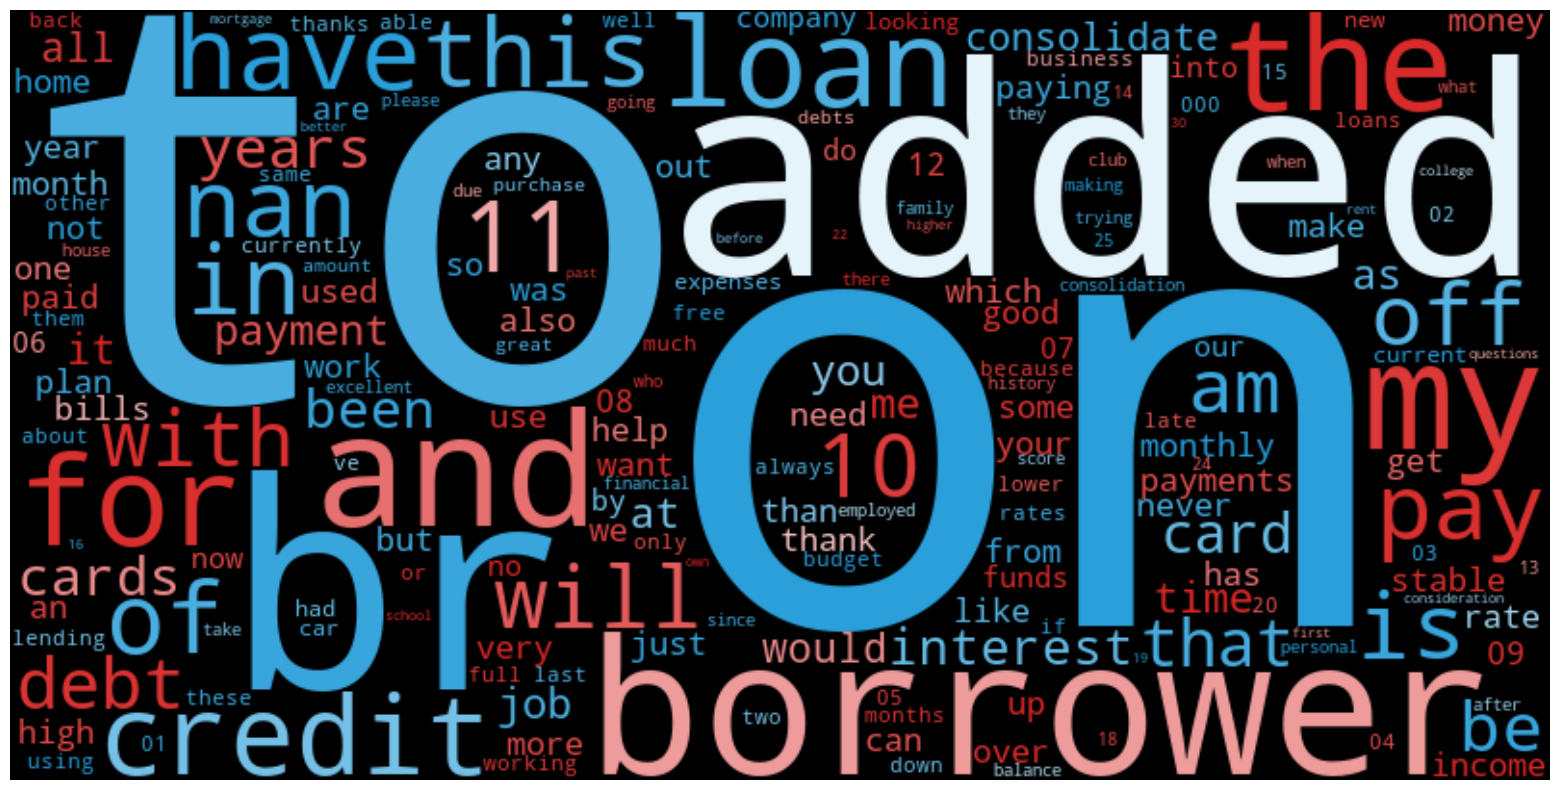

In [8]:
# ワードクラウドで可視化する。
# 閾値を設けてある一定の頻度のものだけ表示にしてもいいかも
# 今後Stopword除去も配慮する
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary where keys are words and values are corresponding wordcounts
wordcounts = dict(zip(df_word_summary['features'], df_word_summary['wordcounts']))

# Define a color function
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    coef = df_word_summary[df_word_summary['features'] == word]['coefs'].values[0]
    if coef > 0:
        return "hsl(0, 70%%, %d%%)" % (50 + coef * 100) # adjust these numbers to change color
    else:
        return "hsl(200, 70%%, %d%%)" % (50 - coef * 100) # adjust these numbers to change color

wordcloud = WordCloud(width=800, height=400, color_func=color_func,
                      prefer_horizontal=1.0).generate_from_frequencies(wordcounts)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [9]:
# making all features
class RunBlocks(Base):
    def __init__(self):
        
        self.feature_blocks = [ordinal_encoding_based_on_frequency_encoding(["grade", "sub_grade","emp_length","home_ownership","verification_status",
                     "purpose","zip_code","addr_state"])]
        self.stacked_predict_feature = [*[text_out_of_fold_prediction(col) for col in ["desc","title"]]]
        self.use_original_values = ["id","loan_amnt","funded_amnt","funded_amnt_inv","term",
                                "int_rate","installment","annual_inc"]
        
    def fit(self,input_df, df_y):
        output_df = pd.DataFrame()
        output_df = input_df[self.use_original_values]
                
        for block in self.feature_blocks:
            output_i = block.fit(input_df)
            assert len(input_df) == len(output_i), block
            output_df = pd.concat([output_df,output_i],axis=1)
        
        for block in self.stacked_predict_feature:
            output_i = block.fit(input_df,df_y)
            assert len(input_df) == len(output_i), block
            output_df = pd.concat([output_df,output_i],axis=1)
        return output_df
    
    def transform(self,input_df):
        output_df = pd.DataFrame()
        output_df = input_df[self.use_original_values]
        
        for block in self.feature_blocks:
            output_i = block.transform(input_df)
            assert len(input_df) == len(output_i), block
            output_df = pd.concat([output_df,output_i],axis=1)
            
        for block in self.stacked_predict_feature:
            output_i = block.transform(input_df)
            assert len(input_df) == len(output_i), block
            output_df = pd.concat([output_df,output_i],axis=1)
        return output_df
        
run_blocks = RunBlocks()
train = run_blocks.fit(df_train, df_train_y)
test = run_blocks.transform(df_test)
train



CV Score of Fold_0 is 0.5768427742609396
CV Score of Fold_1 is 0.5701548366929711
CV Score of Fold_2 is 0.5678656956112647
CV Score of Fold_3 is 0.5809929856177366
CV Score of Fold_4 is 0.5824072957128036
mean score is 0.575652717579143
CV Score of Fold_0 is 0.5637932770359557
CV Score of Fold_1 is 0.549612042877208
CV Score of Fold_2 is 0.5568338041406569
CV Score of Fold_3 is 0.5455345332713749
CV Score of Fold_4 is 0.5670500258568152
mean score is 0.5565647366364022


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,ordinal_grade_grade,ordinal_sub_grade_sub_grade,ordinal_emp_length_emp_length,ordinal_home_ownership_home_ownership,ordinal_verification_status_verification_status,ordinal_purpose_purpose,ordinal_zip_code_zip_code,ordinal_addr_state_addr_state,predicted_desc,predicted_title
0,746087,2500,2500,2500.00000,36,17.49,89.75,43000.0,3,15,8.0,4,2,13,743,43,0.496940,0.515290
1,764500,5000,5000,5000.00000,36,5.42,150.80,60000.0,5,19,7.0,3,0,5,791,37,0.410114,0.506017
2,973488,35000,35000,35000.00000,60,20.89,944.71,158000.0,1,9,8.0,3,1,13,778,36,0.532781,0.517350
3,661374,8000,8000,8000.00000,36,10.00,258.14,78000.0,6,28,3.0,3,0,12,669,47,0.499471,0.348702
4,605843,2400,2400,2400.00000,36,6.17,73.20,35000.0,5,26,10.0,4,2,11,199,39,0.269828,0.352033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30856,999441,13750,13750,13750.00000,36,6.03,418.49,76875.0,5,19,9.0,3,0,12,687,41,0.485461,0.518614
30857,514638,7000,7000,6950.00000,36,7.51,217.77,50000.0,5,34,7.0,4,2,12,796,49,0.355008,0.519307
30858,724585,8000,8000,8000.00000,36,13.06,269.79,50000.0,4,27,10.0,3,2,11,806,49,0.581346,0.525201
30859,674088,9950,9950,9950.00000,36,5.42,300.10,100000.0,5,19,10.0,3,2,11,800,42,0.447960,0.511291


モデリング

In [10]:
import lightgbm as lgb

class Config():
    random_seed = 71
    remove_columns=["id"]
    target_col="target"
    cv_fold=5
    early_stopping_rounds=100
    
    lgb_params = {'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 100,
    'n_jobs': -1,
    'num_leaves': 31,
    'objective': None,
    'random_state': random_seed,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    # 'silent': 'warn',
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0}

class LGBModelTraining():
    def __init__(self):
        self.config = Config()
        self.skf = StratifiedKFold(n_splits=self.config.cv_fold, shuffle=True, random_state=self.config.random_seed)
        self.models =[]
        self.use_cols = [col for col in train.columns if col not in self.config.remove_columns]
        self.oof_predicts = np.zeros(len(train))
        self.test_predicts = np.zeros(len(test))
        self.train_idx_list = []
        self.valid_idx_list = []
        self.scores = []
    
    def fit(self, train, df_train_y):
        for k, (train_idx, valid_idx) in enumerate(self.skf.split(train, df_train_y)):
            print(f"CV fold{k}")
            self.train_idx_list.append(train_idx)
            self.valid_idx_list.append(valid_idx)
            
            X_train, y_train = train.loc[train_idx,self.use_cols], df_train_y[train_idx]
            X_valid, y_valid = train.loc[valid_idx,self.use_cols], df_train_y[valid_idx]
            model = lgb.LGBMClassifier(**self.config.lgb_params,force_row_wise=True,verbose=-1)
            evals = {}
            callbacks = [lgb.early_stopping(self.config.early_stopping_rounds),
                        lgb.record_evaluation(evals)]
            
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=callbacks)
            self.test_predicts += (model.predict_proba(test[self.use_cols])[:,1])
            y_pred = model.predict_proba(X_valid)[:,1]
            score = roc_auc_score(y_valid, y_pred)
            self.oof_predicts[valid_idx]=y_pred
            self.models.append(model)
            self.scores.append(score)
            print(f"Fold {k}:{score}")
        print(f"mean score is {np.mean(self.scores)}")

model = LGBModelTraining()
model.fit(train, df_train_y)

        

CV fold0
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[48]	valid_0's binary_logloss: 0.379239
Fold 0:0.7127482936692717
CV fold1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's binary_logloss: 0.381138
Fold 1:0.7080606129900863
CV fold2
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's binary_logloss: 0.381308
Fold 2:0.711162067160586
CV fold3
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's binary_logloss: 0.387621
Fold 3:0.6935829993276179
CV fold4
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.378288
Fold 4:0.7148002731486677
mean score is 0.7080708492592459


# モデルインサイト

In [45]:
#　カテゴリ値の逆変換用の辞書を定義
reverse_dict = run_blocks.feature_blocks[0].reverse_mappings_

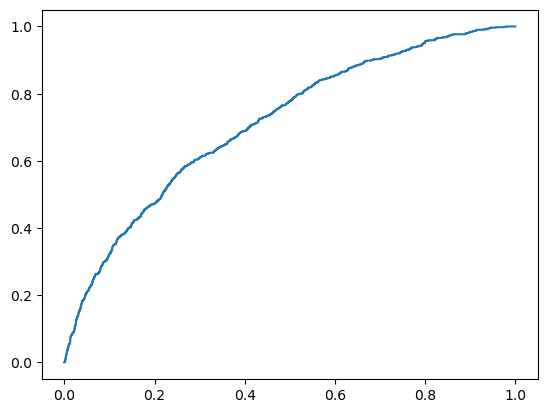

In [12]:
# モデル評価用としてどのFoldを使うかを決める
check_fold = 0
predict_location = model.valid_idx_list[check_fold]
predicts = model.oof_predicts[predict_location]
actuals = df_train_y[predict_location]

# ROC曲線を描く
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(actuals, predicts)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%roc_auc_score(actuals, predicts))


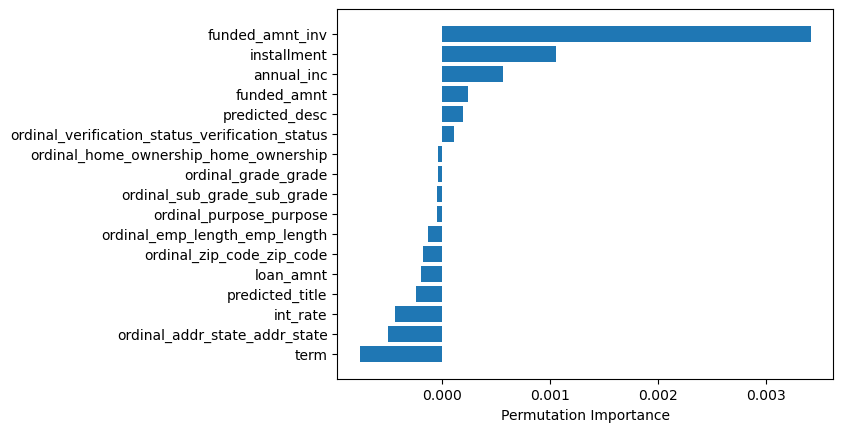

['funded_amnt_inv',
 'installment',
 'annual_inc',
 'funded_amnt',
 'predicted_desc',
 'ordinal_verification_status_verification_status',
 'ordinal_home_ownership_home_ownership',
 'ordinal_grade_grade',
 'ordinal_sub_grade_sub_grade',
 'ordinal_purpose_purpose',
 'ordinal_emp_length_emp_length',
 'ordinal_zip_code_zip_code',
 'loan_amnt',
 'predicted_title',
 'int_rate',
 'ordinal_addr_state_addr_state',
 'term']

In [70]:
# permutationn importanceを計算する
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model.models[check_fold], train.loc[predict_location,model.use_cols], actuals, n_repeats=10, random_state=71)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(train.loc[predict_location,model.use_cols].columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

# 列の名前を重要度順に並び替える
important_column_order = list(train.loc[predict_location,model.use_cols].columns[sorted_idx])
important_column_order.reverse()
important_column_order

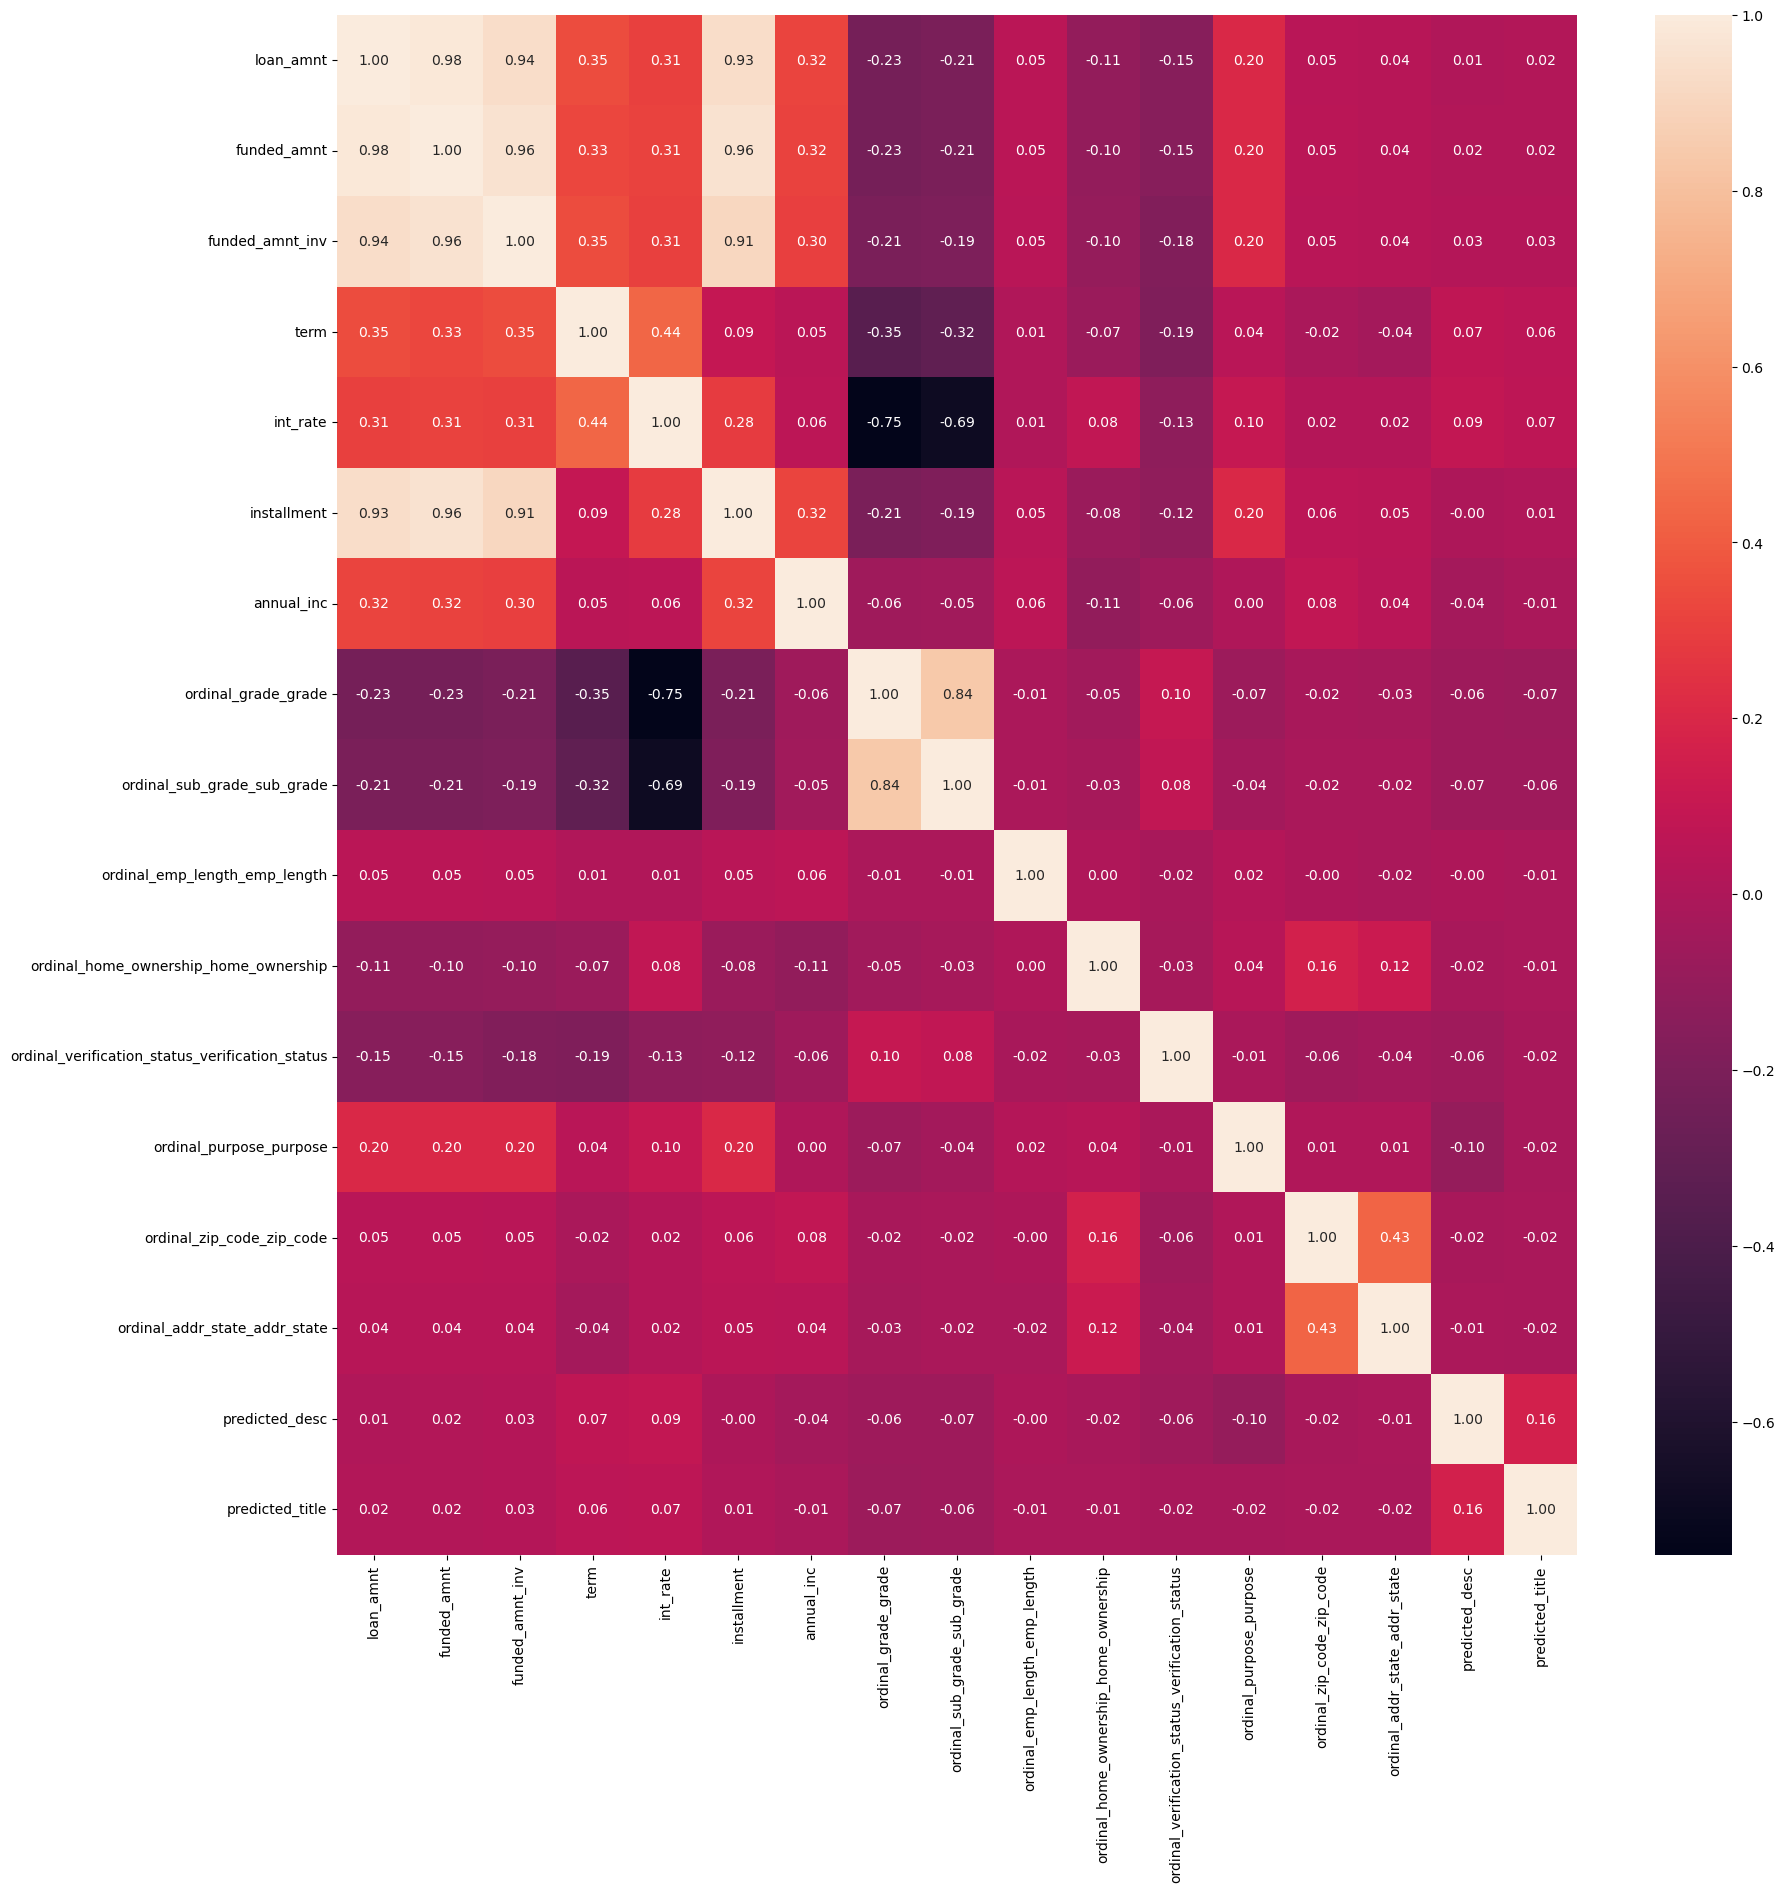

In [14]:
# 相関行列を計算する
import seaborn as sns
plt.figure(figsize=(20, 20))
sns.heatmap(train.loc[predict_location,model.use_cols].corr(), annot=True, fmt='.2f')
plt.show()

Dashアプリケーションによる解釈

In [49]:
import plotly.offline as pyo
import plotly.graph_objs as go

# averagae pdpプロット。層別解釈もできるようにしておく。
def plot_partial_dependence_plot(df, df_y, col, model, reverse_dict=None, stratified_col=None, option=False):

    """
    mainとsubの両方の列を入力した際に、
    option==False：実測と予測のプロットを非表示
    option==True: 実測と予測のプロットを表示
    """
    def make_data_for_plot(df, df_y, col, model, stratified_col=None):
        #　予測と実測は元のトレーニングデータ全体から持ってくる
        #　実測結果とラベルを結合する
        df_all = df.copy()
        predictions = np.array(model.oof_predicts)
        df_all["predictions"]=predictions
        df_all["actuals"]=df_y
        if col not in model.use_cols:
            return
        
        # 層別オプションを実行しているかで処理を分岐
        if stratified_col == None:
            #　シミュレーションに使うデータはサンプリング。n行以下なら全て持ってくる。
            n_sample = 5000
            if len(df)>=n_sample:
                df_sample = df.sample(n=n_sample, random_state=0)
            else:
                df_sample = df.copy()
            return df_sample, df_all
        else:
            stratified_sample_dic = {}
            df_sample = df.copy()
            value_list = df_sample[stratified_col].value_counts().iloc[:50].index
            value_list = sorted(value_list)
            
            #　データを層別して辞書に格納しておく
            for value in value_list:
                stratified_sample_dic[value] = df_sample[df_sample[stratified_col]==value]
            return df_sample, df_all, stratified_sample_dic, value_list
    
    # プロット用のデータを作成する
    def create_df_plot(df_sample, df_all, col, model, reverse_dict=None, stratified_col=None, stratified_value=None):
        # 部分依存用に終変化するため、特定の値だけ同一値で入力して予測
        simu_dic = {}
        
        # 特定値の実測値の集計を辞書でまとめる
        actual_dic = {}
        
        # 特定値の予測の集計を辞書でまとめる
        pred_dic = {}
        
        # データ数を保持
        n_dic = {}
        
        # サンプリングしたデータから頻度の高い上位100の値をシミュレーション用に取得
        for value in df_sample[col].value_counts().iloc[:50].index:
            df_simulate = df_sample.copy()
            df_simulate[col] = value
            #　シミレーション用のデータを予測して結果を取得する
            simu_dic[value] = model.models[0].predict_proba(df_simulate[model.use_cols])[:,1]
            
            #　実測値の集計
            if stratified_col==None:
                actual_dic[value] = df_all.loc[df_all[col]==value, "actuals"].mean()
            else:
                actual_dic[value] = df_all.loc[(df_all[col]==value)&(df_all[stratified_col]==stratified_value), "actuals"].mean()
            
            # 予測値の集計
            if stratified_col==None:
                pred_dic[value] = df_all.loc[df_all[col]==value, "predictions"].mean()
            else:
                pred_dic[value] = df_all.loc[(df_all[col]==value)&(df_all[stratified_col]==stratified_value), "predictions"].mean()
            
            #　データ数の保存
            if stratified_col==None:
                n_dic[value] = len(df_all.loc[df_all[col]==value, "actuals"])
            else:
                n_dic[value] = len(df_all.loc[(df_all[col]==value)&(df_all[stratified_col]==stratified_value), "actuals"])
                
        
    
        # プロット用のデータフレームを作成
        df_plot = pd.DataFrame.from_dict(simu_dic).mean().sort_index().reset_index()
        
        #　カテゴリーのエンコーディングしていた場合には表記を元に戻す
        
        if col in reverse_dict.keys():
            df_plot[col] = df_plot["index"].replace(reverse_dict[col])
        else:
            df_plot[col] = df_plot["index"]
        
            
        df_plot = df_plot.rename(columns={0:"target_average_tendency"})
        
        df_plot["actuals"] = pd.DataFrame.from_dict(actual_dic, orient="index").sort_index().to_numpy()
        df_plot["predictions"] = pd.DataFrame.from_dict(pred_dic, orient="index").sort_index().to_numpy()
        df_plot["データ数"] = pd.DataFrame.from_dict(n_dic, orient="index").sort_index().to_numpy()
        
        return df_plot
    
    def make_data_for_plotly(df_plot, reverse_dict, startified_col=None, stratified_value=None):
        #ターゲット列を指定
        target_col="target"
        
        data = []
        
        #　値の名称を作成
        if stratified_col!=None:
            value_name = stratified_value

        # エンコーディングしていた場合に名前を逆変換
        if stratified_col in reverse_dict.keys():
            value_name = int(value_name)
            for k, v in reverse_dict.items():
                valiue_name = str(value_name).replace(str(k),v)
                
        # カテゴリであれば散布図を作る。数値であればラインプロット(本当は事前に判定しておくべき。)
        if col in reverse_dict.keys():
            mode = "markers"
        else:
            mode = "lines"
        
        if stratified_col==None:
            add_name = ""
        else:
            add_name = f"{stratified_col}_{value_name}_"
        # メインのプロット
        trace_main = go.Scatter(x=df_plot[col], y=df_plot["actuals"], mode=mode, name=f"{add_name}部分依存",
                                hovertemplate="値: %{x}<br>平均ターゲット傾向: %{y}<br>データ数: %{text}",
                                text=df_plot["データ数"])
        data.append(trace_main)
        
        if (stratified_col==None) or (option==True):
            ## 移動平均プロット
            # if mode=="lines":
            #     df_plot["移動平均"] = df_plot["actuals"].rolling(window=3, center=True).mean()
            #     trace_move = go.Scatter(x=df_plot[col], y=df_plot["移動平均"], mode=mode, name="移動平均",
            #                             hovertemplate="値: %{x}<br>平均ターゲット傾向: %{y}<br>データ数: %{text}",
            #                     text=df_plot["データ数"])
            #     data.append(trace_move)
            
            # 実測の集計を入れる
            trace_act = go.Scatter(x=df_plot[col], y=df_plot["actuals"],mode=mode, name="実測の集計",
                                hovertemplate="値: %{x}<br>>平均ターゲット傾向: %{y}<br>データ数：%{text}",
                                text=df_plot["データ数"],visible="legendonly",connectgaps=True)
            data.append(trace_act)

            #　予測の集計を入れる
            trace_prd = go.Scatter(x=df_plot[col], y=df_plot["predictions"],mode=mode, name="予測の集計",
                                hovertemplate="値: %{x}<br>>平均ターゲット傾向: %{y}<br>データ数：%{text}",
                                text=df_plot["データ数"],visible="legendonly",connectgaps=True)
            data.append(trace_prd)

        return data
        
    # Dashで効果をざっくり算出して表示する際のコメント作成 
    def _treatment_effect_est(df_plot, stratified_col=None, stratified_value=None):
        effect_est = round((df_plot["target_average_tendency"].max()-df_plot["target_average_tendency"].min())*100,1)
        if stratified_col==None:
            text = f"平均傾向への影響:{effect_est}pt"
        elif stratified_col in reverse_dict.keys():
            value_name = int(value_name)
            for k, v in reverse_dict.items():
                valiue_name = str(value_name).replace(str(k),v)
            text = f"{stratified_col}:{value_name}の平均傾向への影響:{effect_est}pt"
        else:
            text = f"{stratified_col}:{stratified_value}の平均傾向への影響:{effect_est}pt"
        return text
    
    
    
    text_list = []

    if stratified_col==None:
        df_sample, df_all = make_data_for_plot(df, df_y, col, model)
        df_plot = create_df_plot(df_sample, df_all, col, model, reverse_dict)
        data = make_data_for_plotly(df_plot, reverse_dict)
        text_list.append(_treatment_effect_est(df_plot))
    else:
        df_sample, df_all, stratified_sample_dic, value_list = make_data_for_plot(df, df_y, col, model, stratified_col)
        data = []
        for stratified_value in value_list:
            df_sample = stratified_sample_dic[stratified_value]
            df_plot = create_df_plot(df_sample, df_all, col, model, reverse_dict, stratified_col, stratified_value)
            data += make_data_for_plotly(df_plot, reverse_dict, stratified_col, stratified_value)
            text_list.append(_treatment_effect_est(df_plot, stratified_col, stratified_value))
    layout = go.Layout(title=f"{col}の部分依存プロット", xaxis_title=col, yaxis_title="平均ターゲット傾向")
    fig = go.Figure(data=data, layout=layout)

    return fig, text_list


#　テスト
fig, text_list = plot_partial_dependence_plot(train, df_train_y, "ordinal_addr_state_addr_state", model, reverse_dict, stratified_col="term", option=False)
fig.show()

In [23]:
train.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'annual_inc', 'ordinal_grade_grade',
       'ordinal_sub_grade_sub_grade', 'ordinal_emp_length_emp_length',
       'ordinal_home_ownership_home_ownership',
       'ordinal_verification_status_verification_status',
       'ordinal_purpose_purpose', 'ordinal_zip_code_zip_code',
       'ordinal_addr_state_addr_state', 'predicted_desc', 'predicted_title'],
      dtype='object')

In [56]:
def normal_plot(df_train_x, df_train_y, main_column_name, sub_column_name=None, reverse_dict=None,option=False, count=True):
    """
    mainとsubの両方の列を入力した際に、
    option==False:層別してヒストグラムを描画
    option==True:散布図を描画
    ヒストグラムを描画する際に
    count==True:縦軸がカウント
    count==False:縦軸が頻度
    """
    df_plot = df_train_x.copy()
    df_plot.sort_values(by=main_column_name)

    def binning_and_target_aggregation(df,col):
        # ビニングする必要があるか判定
        if ((df[col].dtype=='int64') or (df[col].dtype=='float64') or (df[col].nunique()>20)) and (col not in reverse_dict.keys()):
            bins = pd.cut(df_plot[col], bins=20)
            df_agg = df.groupby(bins).target.mean().reset_index()
            # ビニングした後に中央値に直している。
            df_agg[col] = df_agg[col].apply(lambda x: x.mid)
        else:
            #　ビニングせずグルーピングして平均ターゲット率を計算する
            df_agg = df.groupby([col]).target.mean().reset_index()
        return df_agg            

    # カテゴリで変換していた場合に値を元に戻す。
    if main_column_name in reverse_dict.keys():
        df_plot[main_column_name] = df_plot[main_column_name].replace(reverse_dict)
    if sub_column_name in reverse_dict.keys():
        df_plot[sub_column_name] = df_plot[sub_column_name].replace(reverse_dict)
    df_plot["target"] = df_train_y
    data = []

    #　ターゲット平均を集計して計算
    if (sub_column_name!=None):
        if option:
            # main_columnとsub_columnで重なる箇所でターゲットを平均
            df_agg = df_plot.groupby([main_column_name, sub_column_name])["target"].agg(["mean","count"]).reset_index()
        else:
            # sub_columnに含まれる値で層別してからmain_columnをビニングし、集計。
            sub_value_list = sorted(df_plot[sub_column_name].value_counts().iloc[:10].index)
            df_agg_dic={}
            for sub_value in sub_value_list:
                df_agg = binning_and_target_aggregation(df_plot[df_plot[sub_column_name]==sub_value],main_column_name)
                df_agg_dic[sub_value]=df_agg
    else:
        # サブ列がない場合はターゲットを集計する際に、メイン列をビニングした値で集計
        df_agg = binning_and_target_aggregation(df_plot,main_column_name)       

    # プロットを作成
    data = []
    if sub_column_name==None:
        df_plot = df_plot.sort_values(by=main_column_name)
        if count:
            data.append(go.Histogram(x=df_plot[main_column_name],nbinsx=20, name = main_column_name))
            layout = go.Layout(title=f"{main_column_name}のヒストグラム", xaxis=dict(title=main_column_name), yaxis=dict(title="カウント数"))
        else:
            data.append(go.Histogram(x=df_plot[main_column_name],nbinsx=20, name = main_column_name, histnorm='percent'))
            layout = go.Layout(title=f"{main_column_name}のヒストグラム", xaxis=dict(title=main_column_name), yaxis=dict(title="割合"))
        df_agg = df_agg.sort_values(by=main_column_name)
        data.append(go.Scatter(x=df_agg[main_column_name], y=df_agg["target"], yaxis='y2', name="Target_ratio",connectgaps=True))

        fig = go.Figure(data=data,layout=layout)
        if count:
            fig.update_layout(yaxis=dict(title="Count"),
                      yaxis2=dict(title="Target ratio", overlaying='y',side='right'))
        else:
            fig.update_layout(yaxis=dict(title="Percent"),
                      yaxis2=dict(title="Target ratio", overlaying='y',side='right'))
    else:
        if option:
            # 散布図を出す。
            hovertemplate=("<b>%{x},%{y}</b><br><br>"
                        "データ数: %{marker.size}<br>"
                        "ターゲット平均: %{marker.color}<extra></extra>")
            data.append(go.Scatter(x=df_agg[main_column_name], y=df_agg[sub_column_name],mode="markers",
                                marker=dict(size=df_agg["count"],color=round(df_agg["mean"],2),opacity=0.5,
                                sizemode='area', sizemin=3,
                                colorbar = dict(title ="Target ratio")
                                ),
                                hovertemplate=hovertemplate))
            fig = go.Figure(data=data)
            fig.update_xaxes(title_text=main_column_name)
            fig.update_yaxes(title_text=sub_column_name)
        else:
            # sub_columnのvalueの数だけ層別してヒストグラムとターゲット平均を描画
            for sub_value in sub_value_list:
                df_plot = df_plot.sort_values(by=main_column_name)
                if count:
                    data.append(go.Histogram(x=df_plot.loc[df_plot[sub_column_name]==sub_value, main_column_name],nbinsx=20, name=sub_value))
                    layout = go.Layout(title=f"{main_column_name}のヒストグラム", xaxis=dict(title=main_column_name), yaxis=dict(title="カウント数"))
                else:
                    data.append(go.Histogram(x=df_plot.loc[df_plot[sub_column_name]==sub_value, main_column_name],nbinsx=20, name=sub_value, histnorm='percent'))
                    layout = go.Layout(title=f"{main_column_name}のヒストグラム", xaxis=dict(title=main_column_name), yaxis=dict(title="割合"))
                df_agg  = df_agg_dic[sub_value]
                df_agg = df_agg.sort_values(by=main_column_name)
                data.append(go.Scatter(x=df_agg[main_column_name], y=df_agg["target"], yaxis='y2', name=f"{sub_value}_Target_ratio",connectgaps=True))
                
            fig = go.Figure(data=data,layout=layout)
            if count:
                fig.update_layout(yaxis=dict(title="Count"), yaxis2=dict(title="Target ratio", overlaying='y',side='right'))
            else:
                fig.update_layout(yaxis=dict(title="Percent"), yaxis2=dict(title="Target ratio", overlaying='y',side='right'))

    return fig

    

normal_plot(train, df_train_y, "term",reverse_dict=reverse_dict)

In [71]:
#　アプリケーションで部分依存を確認
import dash
from dash import dcc
from dash import html
import plotly.express as px
from dash.dependencies import Input, Output,State
import webbrowser
from threading import Timer

app = dash.Dash(__name__)
app.layout = html.Div([
    dcc.Dropdown(
        id='main_column',
        options=[{'label':i, "value": i} for i in important_column_order],
        value = important_column_order[0]
    ),
    dcc.Dropdown(
        id='sub_column',
        options=[{'label':i, "value": i} for i in important_column_order],
        value= None,
    ),
    dcc.RadioItems(
        id='toggle-button',
        options=[{'label':i, 'value':i} for i in ['pdp','plot']],
        value='pdp',
        style={'display':'inline-block'},
        inline=True
    ),
    dcc.Checklist(id='check_box',
                 options=[{"label":"Option","value":"Option"}],
                 style={'display':'inline-block'}),
    dcc.RadioItems(
    id='toggle_count',
    options=[{'label':i, 'value':i} for i in ['count','percent']],
    value='count',
    style={'display':'inline-block'},
    inline=True),
    dcc.Graph(id="indicator-graphic"),
    html.Div(id="dynamic-text", style={"backgroundColor":"lightgrey", "padding":"10px"}),
    dcc.Store(id="store")
    ])

 

@app.callback(
    Output("sub_column","options"),
    Output("sub_column","value"),
    Input("main_column","value")
)

def set_sub_column_option(selected_main):
    return [{'label':i, "value": i} for i in important_column_order if i!=selected_main],None

@app.callback(
    Output("indicator-graphic", "figure"),
    Output("store", "data"),
    Input("main_column","value"),
    Input("sub_column","value"),
    Input("toggle-button","value"),
    Input("check_box","value"),
    Input("toggle_count","value"),
)

# optionのTrue/Falseで実測と予測を出すかを分岐
def update_graph(main_column_name, sub_column_name, figure_value, option, count_percent):    
    if figure_value=="pdp":
        if sub_column_name != None:
            figure,text_list = plot_partial_dependence_plot(train, df_train_y, main_column_name, model, reverse_dict, stratified_col=sub_column_name, option=option)
        else:
            figure,text_list = plot_partial_dependence_plot(train, df_train_y, main_column_name, model, reverse_dict, option=False)

        figure.update_layout(height=600)
    else:
        if sub_column_name != None:
            if option:
                # 散布図を出す。
                figure = normal_plot(train, df_train_y, main_column_name,sub_column_name,reverse_dict,option=True)
            else:
                #　層別したヒストグラムを出す
                if count_percent=="count":
                    # ヒストグラムの縦軸をカウントに変更
                    figure = normal_plot(train, df_train_y, main_column_name,sub_column_name, reverse_dict, count=True)
                else:
                    # ヒストグラムの縦軸を頻度に変更
                    figure = normal_plot(train, df_train_y, main_column_name,sub_column_name, reverse_dict, count=False)
        else:
            if count_percent=="count":
                # ヒストグラムの縦軸をカウントに変更
                figure = normal_plot(train, df_train_y, main_column_name, reverse_dict=reverse_dict, count=True)
            else:
                # ヒストグラムの縦軸を頻度に変更
                figure = normal_plot(train, df_train_y, main_column_name,count=False)
        text_list = [""]
    return figure, text_list
 

@app.callback(
    Output("dynamic-text", "children"),
    Input("store","data")
)

def update_text(text_list):
    if text_list:
        return [html.P(line) for line in text_list]
    return ''
 
def open_browser():
    webbrowser.open_new("http://127.0.0.1:8050/")

if __name__ == "__main__":
    Timer(1, open_browser).start();
    app.run(debug=False)